In [1]:
from typing import Sequence
from functools import partial
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import random
from sklearn.metrics import r2_score

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Part 2: what if the DNA sequences are not the same length

### Approach 2:
First padding the variable length sequences to the maximum size in the batch then using `pack_padded_sequence` and `pad_packed_sequence` operations in the forward method of the model architecture.

In [3]:
# hint we will need following imports
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [4]:
# DO NOT CHANGE HERE
random.seed(13)

# Use this for getting x label
def rand_sequence_var_len(n_seqs: int, lb: int=16, ub: int=128) -> Sequence[int]:
    for i in range(n_seqs):
        seq_len = random.randint(lb, ub)
        yield [random.randint(1, 5) for _ in range(seq_len)]


# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i:i+2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs


# Alphabet helpers   
alphabet = 'NACGT'
dna2int = {a: i for a, i in zip(alphabet, range(1, 6))}
int2dna = {i: a for a, i in zip(alphabet, range(1, 6))}
dna2int.update({"pad": 0})
int2dna.update({0: "<pad>"})

intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [5]:
def prepare_data(num_samples=100, min_len=16, max_len=128):

    X_dna_seqs_train = list(rand_sequence_var_len(num_samples, min_len, max_len))
    #step 2
    temp = list(map(intseq_to_dnaseq, X_dna_seqs_train))
    dna_seqs = [''.join(seq) for seq in temp]
    #step3
    y_dna_seqs = [count_cpgs(seq) for seq in dna_seqs]
    
    return X_dna_seqs_train, y_dna_seqs
    
    
min_len, max_len = 64, 128
train_x, train_y = prepare_data(2048, min_len, max_len)
test_x, test_y = prepare_data(512, min_len, max_len)

In [6]:
print(len(train_x), len(train_y), len(test_x), len(test_y))

2048 2048 512 512


In [7]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, lists, labels) -> None:
        self.lists = lists
        self.labels = labels

    def __getitem__(self, index):
        # Convert sequences to LongTensor
        sequences_tensor = torch.LongTensor(self.lists[index])

        # Convert labels to FloatTensor with unsqueeze to make it 2D
        label_tensor = torch.tensor(self.labels[index], dtype=torch.float32)

        return sequences_tensor, label_tensor

    def __len__(self):
        return len(self.lists)

    
# this will be a collate_fn for dataloader to pad sequence  
class PadSequence:
    def __init__(self, padding_value=0) -> None:
        self.padding_value = padding_value

    def __call__(self, batch):
        # Sort the batch by sequence length in descending order
        batch = sorted(batch, key=lambda x: len(x[0]), reverse=True)
        # Get the sequence and labels from the sorted batch
        sequences, labels = zip(*batch)

        # Get lengths
        lengths = [len(seq) for seq in sequences]

        # Pad the sequence
        padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=self.padding_value)
        
        return padded_sequences, torch.tensor(labels), torch.tensor(lengths)
    

In [8]:
# some config
LSTM_HIDDEN = 16
LSTM_LAYER = 3
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 300
VOCAB_SIZE = 6
OUTPUT_SIZE = 1

In [9]:
train_dataset = MyDataset(train_x, train_y)
test_dataset = MyDataset(test_x, test_y)

pad_sequence_collate_fn = PadSequence(padding_value=dna2int['pad'])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=pad_sequence_collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=pad_sequence_collate_fn, shuffle=True)

In [11]:
class CpGPredictor(torch.nn.Module):
    ''' Simple model that uses a LSTM to count the number of CpGs in a sequence '''
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, output_size):
        super(CpGPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.classifier = nn.Linear(hidden_size, output_size)

    def forward(self, x, lengths, hc=None):

        # Initialize hidden state and cell state if not provided
        if hc is None:
            hc = self.init_hidden(lengths.size(0))

        # Embedding layer
        embedded_x = self.embedding(x)
        
        # Pack the embedded input
        packed_embedded = pack_padded_sequence(embedded_x, lengths, batch_first=True, enforce_sorted=False)

        # LSTM layer
        packed_out, _ = self.lstm(packed_embedded, hc)

        # Unpack the output of the LSTM layer
        out, _ = pad_packed_sequence(packed_out, batch_first=True)

        # Use the output from the last time step for classification
        out = self.classifier(out[:, -1, :])

        return out
    
    def init_hidden(self, batch_size):
        # Initialize hidden state and cell state with zeros
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))


In [12]:
# init model / loss function / optimizer etc.
model = CpGPredictor(vocab_size=VOCAB_SIZE, embedding_dim=16, hidden_size=LSTM_HIDDEN, num_layers=LSTM_LAYER, output_size=OUTPUT_SIZE)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [116]:
# training (you can modify the code below)

# Initialize Losses
train_losses = []
test_losses = []

train_r2 = []
test_r2 = []

# Initialize hidden state
hc = model.init_hidden(BATCH_SIZE)

for epoch in range(NUM_EPOCHS):
    
    # Set the model on training mode.
    model.train()

    # Initialize batch losses
    train_batch_losses = []
    test_batch_losses = []

    train_batch_r2 = []
    test_batch_r2 = []
    
    for X, y, lengths in train_loader:

        y_hat = model(X, lengths, hc)

        # Compute Loss
        loss = loss_fn(y_hat, y.unsqueeze(1))

        # Compute r2
        r2 = r2_score(y.detach().numpy(), y_hat.detach().numpy())

        # Backprop and Optimzation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the batch loss
        train_batch_losses.append(loss.item())
        train_batch_r2.append(r2)
    
    # Average the batch losses and store as a global loss
    train_losses.append(np.mean(train_batch_losses))
    train_r2.append(np.mean(train_batch_r2))

    # Set the model on evaluation mode.
    model.eval()
    for X, y, lengths in test_loader:
        with torch.no_grad():

            y_hat = model(X,lengths, hc)
            loss = loss_fn(y_hat, y.unsqueeze(1))
            r2 = r2_score(y.detach().numpy(), y_hat.detach().numpy())

            test_batch_losses.append(loss.item())
            test_batch_r2.append(r2)

    # Average loss across the batches
    test_losses.append(np.mean(test_batch_losses))
    test_r2.append(np.mean(test_batch_r2))
    
    print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train_r2: {train_r2[-1]:.4f}, Test_r2: {test_r2[-1]:4f}')

Epoch [1/300], Train Loss: 16.2805, Test Loss: 16.5336, Train_r2: -3.5554, Test_r2: -3.252648
Epoch [2/300], Train Loss: 16.1237, Test Loss: 16.3518, Train_r2: -3.5491, Test_r2: -3.193442
Epoch [3/300], Train Loss: 15.9364, Test Loss: 16.1715, Train_r2: -3.4356, Test_r2: -3.305890
Epoch [4/300], Train Loss: 15.7334, Test Loss: 15.8350, Train_r2: -3.4079, Test_r2: -3.049651
Epoch [5/300], Train Loss: 15.5508, Test Loss: 15.8193, Train_r2: -3.3399, Test_r2: -3.059003
Epoch [6/300], Train Loss: 15.4187, Test Loss: 15.5526, Train_r2: -3.3130, Test_r2: -3.016282
Epoch [7/300], Train Loss: 15.2477, Test Loss: 15.4343, Train_r2: -3.2934, Test_r2: -3.020202
Epoch [8/300], Train Loss: 15.1259, Test Loss: 15.3104, Train_r2: -3.2148, Test_r2: -2.941320
Epoch [9/300], Train Loss: 15.0238, Test Loss: 15.3170, Train_r2: -3.1591, Test_r2: -2.936720
Epoch [10/300], Train Loss: 14.8717, Test Loss: 15.1238, Train_r2: -3.1202, Test_r2: -2.901798
Epoch [11/300], Train Loss: 14.8344, Test Loss: 14.9720, Tr

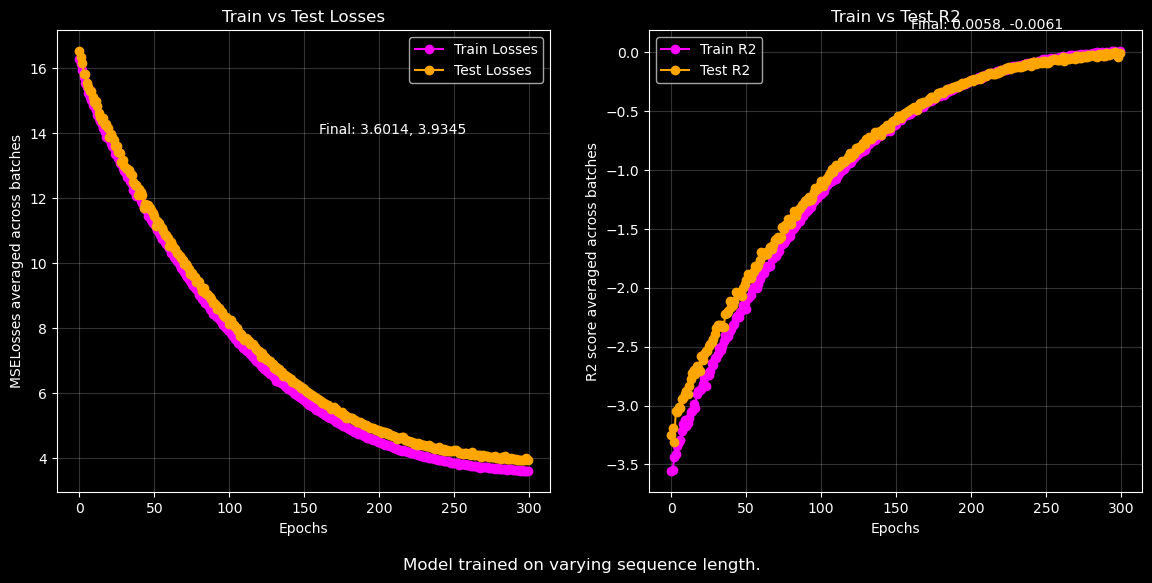

In [117]:
plt.style.use('dark_background')
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(train_losses, '-o', color='magenta', label='Train Losses')
axs[0].plot(test_losses, '-o', color='orange', label='Test Losses')
axs[0].set_title("Train vs Test Losses")
axs[0].set_ylabel("MSELosses averaged across batches")
axs[0].set_xlabel("Epochs")
axs[0].text(160, 14, f"Final: {train_losses[-1]:.4f}, {test_losses[-1]:.4f}")
axs[0].grid(alpha=0.2)
axs[0].legend()

axs[1].plot(train_r2, '-o', color='magenta', label='Train R2')
axs[1].plot(test_r2, '-o', color='orange', label='Test R2')
axs[1].set_title("Train vs Test R2")
axs[1].set_ylabel("R2 score averaged across batches")
axs[1].set_xlabel("Epochs")
axs[1].grid(alpha=0.2)
axs[1].text(160, 0.2, f"Final: {train_r2[-1]:.4f}, {test_r2[-1]:.4f}")
axs[1].legend()
plt.suptitle('Model trained on varying sequence length.', y=0)
plt.show()